In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
tr_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"
ts_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv"

train_df = pd.read_csv(tr_path)
test_df = pd.read_csv(ts_path)

In [3]:
scale_factor = 1000.0

train_df["median_house_value"] /= scale_factor 

test_df["median_house_value"] /= scale_factor

train_df = train_df.reindex(np.random.permutation(train_df.index))

In [4]:
class FloatModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(2, 1)

    def forward(self, x):
        return self.layer(x)

In [11]:
def train_model(model, dataset, epochs, batch_size, label_name, my_lr):
    train_loss_values = []
    val_loss_values = []
    
    criterion = nn.MSELoss()
    optimizer = optim.RMSprop(model.parameters(), lr=my_lr)
    
    features = torch.tensor(np.concatenate([dataset['latitude'].values[:, np.newaxis],
                                            dataset['longitude'].values[:, np.newaxis]],
                                           axis=1), dtype=torch.float32)
    
    label = torch.tensor(dataset[label_name].values, dtype=torch.float32).unsqueeze(1)
    
    dataset = torch.utils.data.TensorDataset(features, label)
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        model.train()
        tr_epoch_loss = 0.0
        for batch_feature, batch_label in dataloader:
            train_preds = model(batch_feature)
            train_loss = criterion(train_preds, batch_label)
            tr_epoch_loss += train_loss.item()
            optimizer.zero_grad()   
            train_loss.backward()   
            optimizer.step()
        train_loss_values.append(tr_epoch_loss / len(dataloader))
        
        print(f"Epoch: {epoch} | Train Loss: {tr_epoch_loss / len(dataloader)}")
    
    return train_loss_values

In [12]:
learning_rate = 0.05
epochs = 30
batch_size = 1000

model = FloatModel()

In [13]:
tr_loss = train_model(model, train_df, epochs, batch_size,
                      'median_house_value', learning_rate)

Epoch: 0 | Train Loss: 18772.28596047794
Epoch: 1 | Train Loss: 13516.613740808823
Epoch: 2 | Train Loss: 13512.448701746323
Epoch: 3 | Train Loss: 13508.63907398897
Epoch: 4 | Train Loss: 13506.384765625
Epoch: 5 | Train Loss: 13503.35041360294
Epoch: 6 | Train Loss: 13502.150620404413
Epoch: 7 | Train Loss: 13493.63396139706
Epoch: 8 | Train Loss: 13490.413775275736
Epoch: 9 | Train Loss: 13488.80939797794
Epoch: 10 | Train Loss: 13480.248334099264
Epoch: 11 | Train Loss: 13476.168198529413
Epoch: 12 | Train Loss: 13469.78532858456
Epoch: 13 | Train Loss: 13482.197897518383
Epoch: 14 | Train Loss: 13451.592256433823
Epoch: 15 | Train Loss: 13455.784524356617
Epoch: 16 | Train Loss: 13452.84357766544
Epoch: 17 | Train Loss: 13439.339096966913
Epoch: 18 | Train Loss: 13428.07306985294
Epoch: 19 | Train Loss: 13421.329733455883
Epoch: 20 | Train Loss: 13426.458237591913
Epoch: 21 | Train Loss: 13417.82657398897
Epoch: 22 | Train Loss: 13387.274758731617
Epoch: 23 | Train Loss: 13398.318

In [15]:
def plot_the_loss_curve(epochs, tr_error):
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Root Mean Squared Error")
    tr_error = np.sqrt(tr_error)
    plt.plot(epochs, tr_error, label="Training Loss")
    plt.legend()
    plt.show()

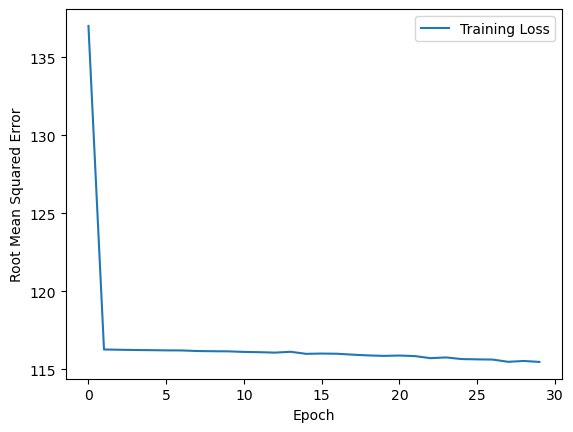

In [16]:
plot_the_loss_curve(range(epochs), np.array(tr_loss))

> ### Represent latitude and longitude in buckets

In [17]:
resolution_in_degrees = 1.0

latitude_boundaries = list(np.arange(int(min(train_df['latitude'])),
                                     int(max(train_df['latitude'])),
                                     resolution_in_degrees))

print("latitude boundaries: " + str(latitude_boundaries))

latitude boundaries: [32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0]


In [18]:
latitude_boundaries = torch.tensor(latitude_boundaries, dtype=torch.float32)

latitude_input = torch.tensor(train_df['latitude'], dtype=torch.float32)

discretized_latitude = torch.bucketize(latitude_input, latitude_boundaries)

num_bins = discretized_latitude.max().item() + 1

one_hot_encoded_latitude = torch.nn.functional.one_hot(discretized_latitude,
                                                       num_classes=num_bins)

In [20]:
longitude_boundaries = list(np.arange(int(min(train_df['longitude'])),
                                      int(max(train_df['longitude'])),
                                      resolution_in_degrees))

print("longitude boundaries: " + str(longitude_boundaries))

longitude boundaries: [-124.0, -123.0, -122.0, -121.0, -120.0, -119.0, -118.0, -117.0, -116.0, -115.0]


In [21]:
longitude_boundaries = torch.tensor(longitude_boundaries, dtype=torch.float32)

longitude_input = torch.tensor(train_df['longitude'], dtype=torch.float32)

discretized_longitude = torch.bucketize(longitude_input, longitude_boundaries)

num_bins = discretized_longitude.max().item() + 1

one_hot_encoded_longitude = torch.nn.functional.one_hot(discretized_longitude,
                                                       num_classes=num_bins)

In [22]:
concatenated_encoded_inputs = torch.cat((one_hot_encoded_latitude,
                                         one_hot_encoded_longitude), dim=-1)

concatenated_encoded_inputs = concatenated_encoded_inputs.type(torch.float32)

In [23]:
class OneHotEncodedModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(21, 1)

    def forward(self, x):
        return self.layer(x)
    
def train_model(model, train_df, encoded_input, epochs, batch_size, label_name, my_lr):
    train_loss_values = []
    
    criterion = nn.MSELoss()
    optimizer = optim.RMSprop(model.parameters(), lr=my_lr)
    
    label = torch.tensor(train_df[label_name].values, dtype=torch.float32).unsqueeze(1)
    
    dataset = torch.utils.data.TensorDataset(encoded_input, label)
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    for epoch in range(epochs):
        model.train()
        tr_epoch_loss = 0.0
        for batch_feature, batch_label in dataloader:
            train_preds = model(batch_feature)
            train_loss = criterion(train_preds, batch_label)
            tr_epoch_loss += train_loss.item()
            optimizer.zero_grad()   
            train_loss.backward()   
            optimizer.step()
        train_loss_values.append(tr_epoch_loss / len(dataloader))
        
        print(f"Epoch: {epoch} | Train Loss: {tr_epoch_loss / len(dataloader)}")
    
    return train_loss_values

In [24]:
learning_rate = 0.04
epochs = 35
batch_size = 100

model = OneHotEncodedModel()

In [25]:
tr_loss = train_model(model, train_df, concatenated_encoded_inputs,
                      epochs, batch_size, 'median_house_value', learning_rate)

Epoch: 0 | Train Loss: 48543.93095128676
Epoch: 1 | Train Loss: 40638.93815487132
Epoch: 2 | Train Loss: 34693.95865119485
Epoch: 3 | Train Loss: 29612.933628216913
Epoch: 4 | Train Loss: 25272.007571231617
Epoch: 5 | Train Loss: 21617.548552389704
Epoch: 6 | Train Loss: 18616.006686580884
Epoch: 7 | Train Loss: 16207.529578354779
Epoch: 8 | Train Loss: 14357.015670955883
Epoch: 9 | Train Loss: 12988.76104664522
Epoch: 10 | Train Loss: 12040.143247357537
Epoch: 11 | Train Loss: 11425.761575137867
Epoch: 12 | Train Loss: 11052.896156939338
Epoch: 13 | Train Loss: 10838.59399988511
Epoch: 14 | Train Loss: 10708.884021714155
Epoch: 15 | Train Loss: 10626.513131893382
Epoch: 16 | Train Loss: 10574.007246668198
Epoch: 17 | Train Loss: 10538.899462890626
Epoch: 18 | Train Loss: 10514.831097771139
Epoch: 19 | Train Loss: 10496.475643382353
Epoch: 20 | Train Loss: 10481.526752068015
Epoch: 21 | Train Loss: 10469.174505974264
Epoch: 22 | Train Loss: 10457.506666475183
Epoch: 23 | Train Loss: 10

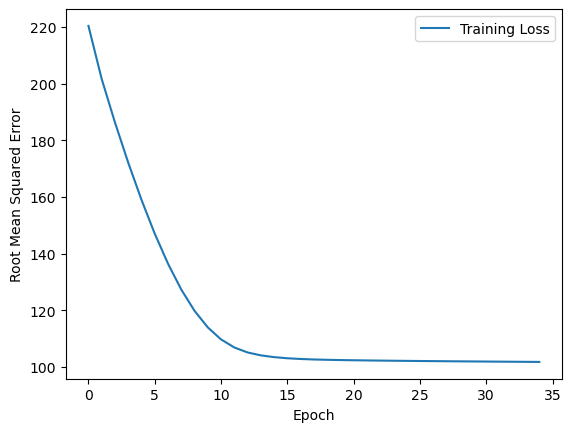

In [26]:
plot_the_loss_curve(range(epochs), np.array(tr_loss))